In [17]:
import pandas as pd

In [18]:
df = pd.read_excel(r"batch_details.xlsx")

In [19]:
df.columns.dtype

dtype('O')

In [20]:
print(df.columns.tolist())


['FORMULA_ID', 'SCRAP_FACTOR', 'ROUTING_ID', 'WIP_BATCH_ID', 'WIP_BATCH_NO', 'WIP_ACT_START_DATE', 'WIP_CMPLT_DATE', 'BATCH_CLOSE_DATE', 'LINE_NO', 'WIP_TYPE', 'TRANSACTION_TYPE_NAME', 'INVENTORY_ITEM_ID', 'TRANSACTION_UOM', 'PLAN_QTY', 'ORIGINAL_QTY', 'WIP_QTY', 'WIP_PERIOD_NAME', 'WIP_RATE', 'WIP_VALUE', 'WIP_BATCH_STATUS', 'WIP_LOT_NUMBER', 'REASON', 'RESOURC']


### 📊 Batch Processing Time Distribution  

**What it shows:**  
- Distribution of how long batches take to complete.  
- The red dashed line indicates the **delay threshold (2 days)**.  

**Insights:**  
- Helps identify whether most batches are completed on time or delayed.  
- A concentration of batches above 2 days highlights **systemic delays or bottlenecks**.  
- Very high processing times (long tail) indicate **exception cases** that may need root cause analysis.  


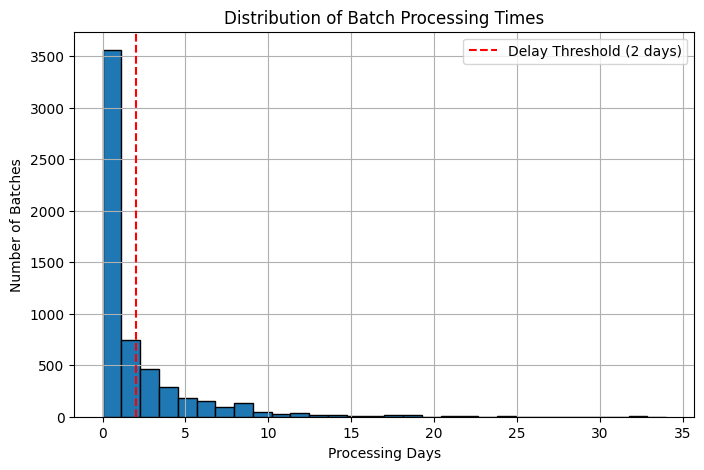

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime
df["WIP_ACT_START_DATE"] = pd.to_datetime(df["WIP_ACT_START_DATE"])
df["WIP_CMPLT_DATE"] = pd.to_datetime(df["WIP_CMPLT_DATE"])

# Calculate processing days at batch level (not row level)
batch_processing = (
    df.groupby("WIP_BATCH_ID")
      .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
      .reset_index()
)
batch_processing["processing_days"] = (
    (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
)

# Plot distribution
plt.figure(figsize=(8,5))
batch_processing["processing_days"].hist(bins=30, edgecolor="black")
plt.axvline(2, color="red", linestyle="--", label="Delay Threshold (2 days)")
plt.title("Distribution of Batch Processing Times")
plt.xlabel("Processing Days")
plt.ylabel("Number of Batches")
plt.legend()
plt.show()




# # What this chart shows
# - A **histogram** of batch-level processing times (`processing_days`).  
# - The **x-axis** shows how many days each batch took to complete.  
# - The **y-axis** shows the number of batches falling in each time range.  
# - The **red dashed line at 2 days** marks the **delay threshold**.  

# # Insights you can derive
# 1. **Most batches are fast**  
#    - The bulk of batches finish within **0–2 days**, clustering left of the threshold line.  
#    - This indicates the process is generally efficient for a majority of runs.  

# 2. **Significant delayed tail**  
#    - There is a **long tail to the right**, with some batches taking much longer (5–10+ days, even beyond 20 days).  
#    - These extended outliers suggest **specific bottlenecks or exceptional cases** that require deeper investigation.  

# 3. **Delay threshold exceedances** 
#    - A notable number of batches cross the **2-day delay threshold**, visible as bars to the right of the red line.  
#    - These represent the **share of batches at risk** for customer service or operational performance metrics.  

# 4. **Operational variability**  
#    - The spread of the distribution shows that while most processes are tightly controlled, there’s **variability across certain batches**.  
#    - Identifying root causes (equipment issues, material shortages, product type differences) can reduce this variability.  



### ⏱️ Distribution of Batch Processing Times  

**What this chart shows:**  
- The histogram displays how many batches fall into different **processing time ranges (in days)**.  
- The red dashed line marks the **delay threshold of 2 days**.  

**Insights:**  
- If most batches are clustered left of the red line → production is generally **on time**.  
- If many batches fall to the right → indicates **frequent delays**.  
- Long right-side tail → a few **outlier batches** take significantly longer, worth investigating.  
- Overall, this visualization helps determine if delays are **systemic (majority above threshold)** or **exception-based (few outliers)**.  


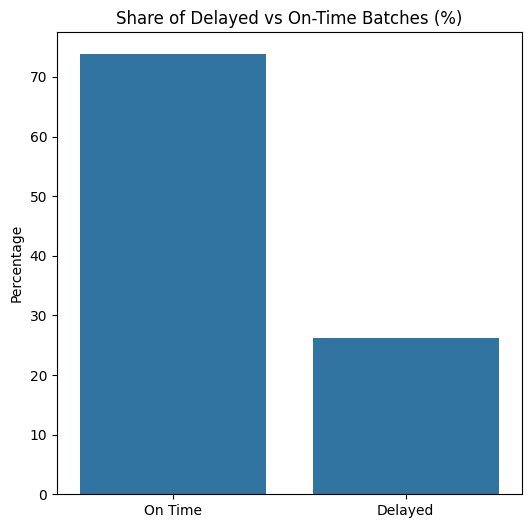

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute batch-level processing days
batch_processing = (
    df.groupby("WIP_BATCH_ID")
      .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
      .reset_index()
)
batch_processing["processing_days"] = (
    (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
)

# Flag delayed batches
batch_processing["is_delayed"] = batch_processing["processing_days"] > 2

# Calculate percentage share
delay_counts = batch_processing["is_delayed"].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(6,6))
sns.barplot(
    x=delay_counts.index.map({True: "Delayed", False: "On Time"}), 
    y=delay_counts.values
)
plt.title("Share of Delayed vs On-Time Batches (%)")
plt.ylabel("Percentage")
plt.xlabel("")
plt.show()



# # What this chart shows
# - A **bar chart** comparing the percentage of **on-time vs delayed batches**.  
# - About **74% of batches finish within the 2-day threshold** (on time).  
# - Around **26% of batches exceed the 2-day threshold** (delayed).  

# # Insights you can derive
# 1. **Overall performance**
#    - The majority of batches are completed on time, showing that the process is generally reliable.  
#    - However, with **1 in 4 batches delayed**, delays are not rare and could impact production flow and delivery schedules.  

# 2. **Room for improvement**
#    - Reducing the delayed portion even by a few percentage points could yield major improvements in throughput, capacity utilization, and customer satisfaction.  

# 3. **Business impact**
#    - If delayed batches involve high-value products or critical customer orders, the **real-world impact is larger than the percentage suggests**.  
#    - Understanding which formulas or lines contribute most to delays will help prioritize improvement efforts.  

# # Suggested next steps
# - **Break down delay rates by line, formula, or product family** to identify where the 26% delays originate.  
# - **Quantify financial impact** by linking delayed batches to WIP value and lost opportunity.  
# - **Investigate recurring causes** (material shortages, equipment downtime, planning issues) for delayed batches.  
# - **Set improvement targets**, e.g., reduce delays from 26% → 15% over the next quarter.  


**What this chart shows:**

- Displays the **average batch processing time per month**.  
- The red dashed line marks the **2-day delay threshold**.  

**Insights you can derive:**
- If the line stays mostly below 2, processes are on time.  
- If it fluctuates above 2 in certain months, those periods may face bottlenecks or workload surges.  
- Helps detect **seasonal or operational patterns** (e.g., recurring delays in specific months).  


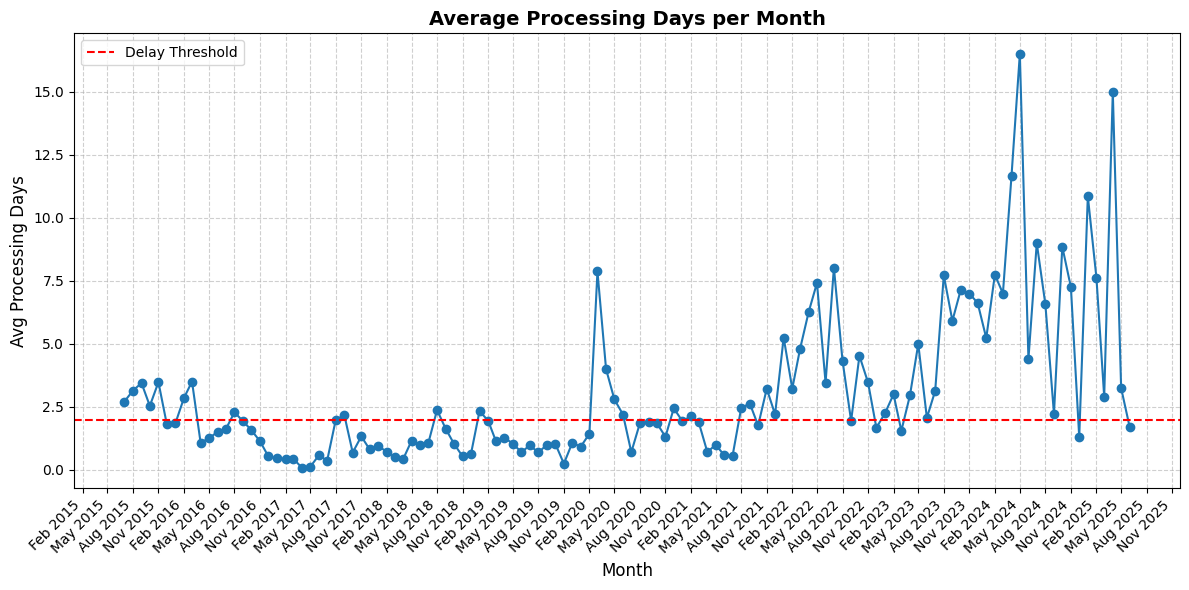

In [23]:
# Compute batch-level processing days
batch_processing = (
    df.groupby("WIP_BATCH_ID")
      .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
      .reset_index()
)
batch_processing["processing_days"] = (
    (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
)

# Extract month from start date
batch_processing["month"] = batch_processing["WIP_ACT_START_DATE"].dt.to_period("M")

# Monthly average processing days
monthly_delay = (
    batch_processing.groupby("month")["processing_days"]
    .mean()
    .reset_index()
)

# Plot
# plt.figure(figsize=(10,5))
# plt.plot(monthly_delay["month"].astype(str), monthly_delay["processing_days"], marker="o")
# plt.axhline(2, color="red", linestyle="--", label="Delay Threshold")
# plt.title("Average Processing Days per Month")
# plt.xlabel("Month")
# plt.ylabel("Avg Processing Days")
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert Period to Timestamp
monthly_delay["month"] = monthly_delay["month"].dt.to_timestamp()

plt.figure(figsize=(12,6))
plt.plot(monthly_delay["month"], monthly_delay["processing_days"], marker="o")
plt.axhline(2, color="red", linestyle="--", label="Delay Threshold")

plt.title("Average Processing Days per Month", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Avg Processing Days", fontsize=12)

# Format x-axis for clarity (quarterly ticks)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



# # What this chart shows
# - A **time-series line chart** of the **average batch processing days per month**.  
# - A **red dashed line marks the 2-day threshold** (delay benchmark).  
# - Early months mostly stayed **below or near the threshold**.  
# - In later months, the **average processing time increases sharply**, with several months exceeding **5–10 days on average**.

# # Insights you can derive
# 1. **Early stability, later deterioration**
#    - Initially, batch processing was controlled and consistently **under 2 days** on average.  
#    - Over time, processing days **spiked significantly**, showing a **deterioration in performance**.  

# 2. **Clear upward trend**
#    - From the mid-point of the timeline, averages began creeping upward, suggesting **systematic delays** (e.g., demand surge, capacity bottlenecks, resource shortages).  
#    - The peaks reaching **10–15+ days** highlight **severe operational inefficiencies** in certain months.  

# 3. **Threshold breaches are frequent in later periods**
#    - In the first half, breaches of the 2-day delay threshold were rare.  
#    - In the second half, **delays became the norm rather than the exception**.  

# # Suggested next steps
# - **Root cause analysis by time period**: Identify what changed during the months when delays started trending upward (e.g., seasonal demand, machine breakdowns, supplier issues).  
# - **Correlate with production volumes**: Check whether spikes coincide with high WIP loads or new product launches.  
# - **Operational interventions**:  
#   - Add capacity or shifts during peak months.  
#   - Rebalance workloads across lines.  
#   - Improve preventive maintenance to avoid bottlenecks.  
# - **Set monitoring alerts**: Flag when average monthly processing days exceed **2–3 days**, so corrective actions can be taken early.  



**What this chart shows:**

- Displays the **average processing time per production line (LINE_NO)**.  
- The red dashed line marks the **2-day delay threshold**.  

**Insights you can derive:**
- Lines consistently above the threshold may signal **process inefficiency** or **capacity issues**.  
- Lines below the threshold are performing well in terms of timely processing.  
- Comparing across lines helps identify **best-performing lines** vs. those requiring improvement.  
- Outliers (very high averages) could indicate **machine downtime, operator issues, or product-specific complexity**.  


In [24]:
df.columns

Index(['FORMULA_ID', 'SCRAP_FACTOR', 'ROUTING_ID', 'WIP_BATCH_ID',
       'WIP_BATCH_NO', 'WIP_ACT_START_DATE', 'WIP_CMPLT_DATE',
       'BATCH_CLOSE_DATE', 'LINE_NO', 'WIP_TYPE', 'TRANSACTION_TYPE_NAME',
       'INVENTORY_ITEM_ID', 'TRANSACTION_UOM', 'PLAN_QTY', 'ORIGINAL_QTY',
       'WIP_QTY', 'WIP_PERIOD_NAME', 'WIP_RATE', 'WIP_VALUE',
       'WIP_BATCH_STATUS', 'WIP_LOT_NUMBER', 'REASON', 'RESOURC'],
      dtype='object')

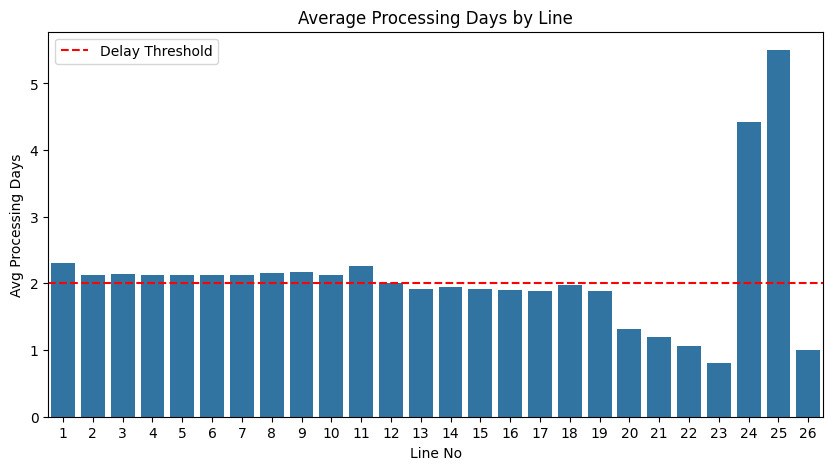

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Step 1: Calculate processing_days directly in df
df["processing_days"] = (df["WIP_CMPLT_DATE"] - df["WIP_ACT_START_DATE"]).dt.days

# ✅ Step 2: Group by line to compute average processing days
delay_by_line = df.groupby("LINE_NO")["processing_days"].mean().reset_index()

# ✅ Step 3: Plot
plt.figure(figsize=(10,5))
sns.barplot(x="LINE_NO", y="processing_days", data=delay_by_line)
plt.axhline(2, color="red", linestyle="--", label="Delay Threshold")
plt.title("Average Processing Days by Line")
plt.xlabel("Line No")
plt.ylabel("Avg Processing Days")
plt.legend()
plt.show()



# # What this chart shows
# - A **bar chart of average processing days by production line**.  
# - A **red dashed line at 2 days** marks the threshold for delays.  
# - Most lines hover around **~2 days or below**, staying close to or under the benchmark.  
# - However, a few lines (notably **Line 24 and Line 25**) have **very high averages (4–5+ days)**, standing out as clear bottlenecks.

# # Insights you can derive
# 1. **Overall performance is stable for most lines**
#    - Lines 1–22 are **well within control**, averaging near or below the 2-day threshold.  
#    - These lines show **balanced efficiency** with minimal variation.  

# 2. **Critical bottlenecks**
#    - **Line 24 and Line 25** are major outliers with averages **double or more** the acceptable limit.  
#    - These lines are the **biggest contributors to system-wide delays**.  

# 3. **Best performing lines**
#    - Lines 21–23 average **well below 2 days**, even under 1 day in some cases.  
#    - These can serve as **benchmarks for best practices** that may be replicated elsewhere.  

# # Suggested next steps
# - **Deep-dive into Line 24 & 25**:  
#   - Check for capacity constraints, equipment issues, or staffing shortages.  
#   - Investigate if product mix or complexity on these lines is higher.  

# - **Benchmark against top performers (Lines 21–23)**:  
#   - Analyze what operational strategies, scheduling, or resourcing helps them stay efficient.  

# - **Balance workloads**:  
#   - If possible, redistribute high-load batches from Lines 24–25 to underutilized lines.  

# - **Continuous monitoring**:  
#   - Regularly track average processing days per line to quickly detect new bottlenecks.  



# What this chart shows
- **Average processing days per month**, split by **production line (`LINE_NO`)**.  
- Each series represents a line’s monthly average cycle time.  
- The **red dashed line at 2 days** is a **delay threshold**—values above it indicate late/slow processing.

# Insights you can derive
1. **Line-to-line performance**
   - Identify lines consistently **below 2 days** (efficient) vs. those **often above 2 days** (bottlenecks).
   - Persistent lag on specific lines can hint at **equipment reliability**, **staffing**, or **product-mix complexity** on those lines.

2. **Temporal/seasonal patterns**
   - **Synchronized spikes across many lines** suggest plant-wide pressures (e.g., material shortages, surges in demand, maintenance outages).
   - **Isolated spikes on one/few lines** point to **localized issues** (machine downtime, operator learning curves, line-specific SKUs).

3. **Stability vs. variability**
   - **Flat, steady curves** indicate predictable flow and good control.
   - **Jagged, volatile curves** imply irregular inputs (materials), **batch sizing variance**, or **scheduling gaps**.

4. **Threshold compliance and risk**
   - Any line **consistently above 2 days** is a **capacity/throughput risk**; prioritize root-cause analysis and relief actions.
   - **Occasional exceedances** may be acceptable, but **repeated monthly breaches** indicate systemic inefficiency to address.

# Useful follow-ups (optional)
- **Drill down by SKU/product family** on the worst-performing lines to see if delays are product-specific.  
- **Overlay WIP volume or batch count** per line/month to test whether higher load correlates with longer cycle time.  
- **Compare planned vs. actual quantities** to check if overproduction or rework inflates time.  
- **Annotate known events** (maintenance, supplier issues) to explain peaks and prevent recurrence.  


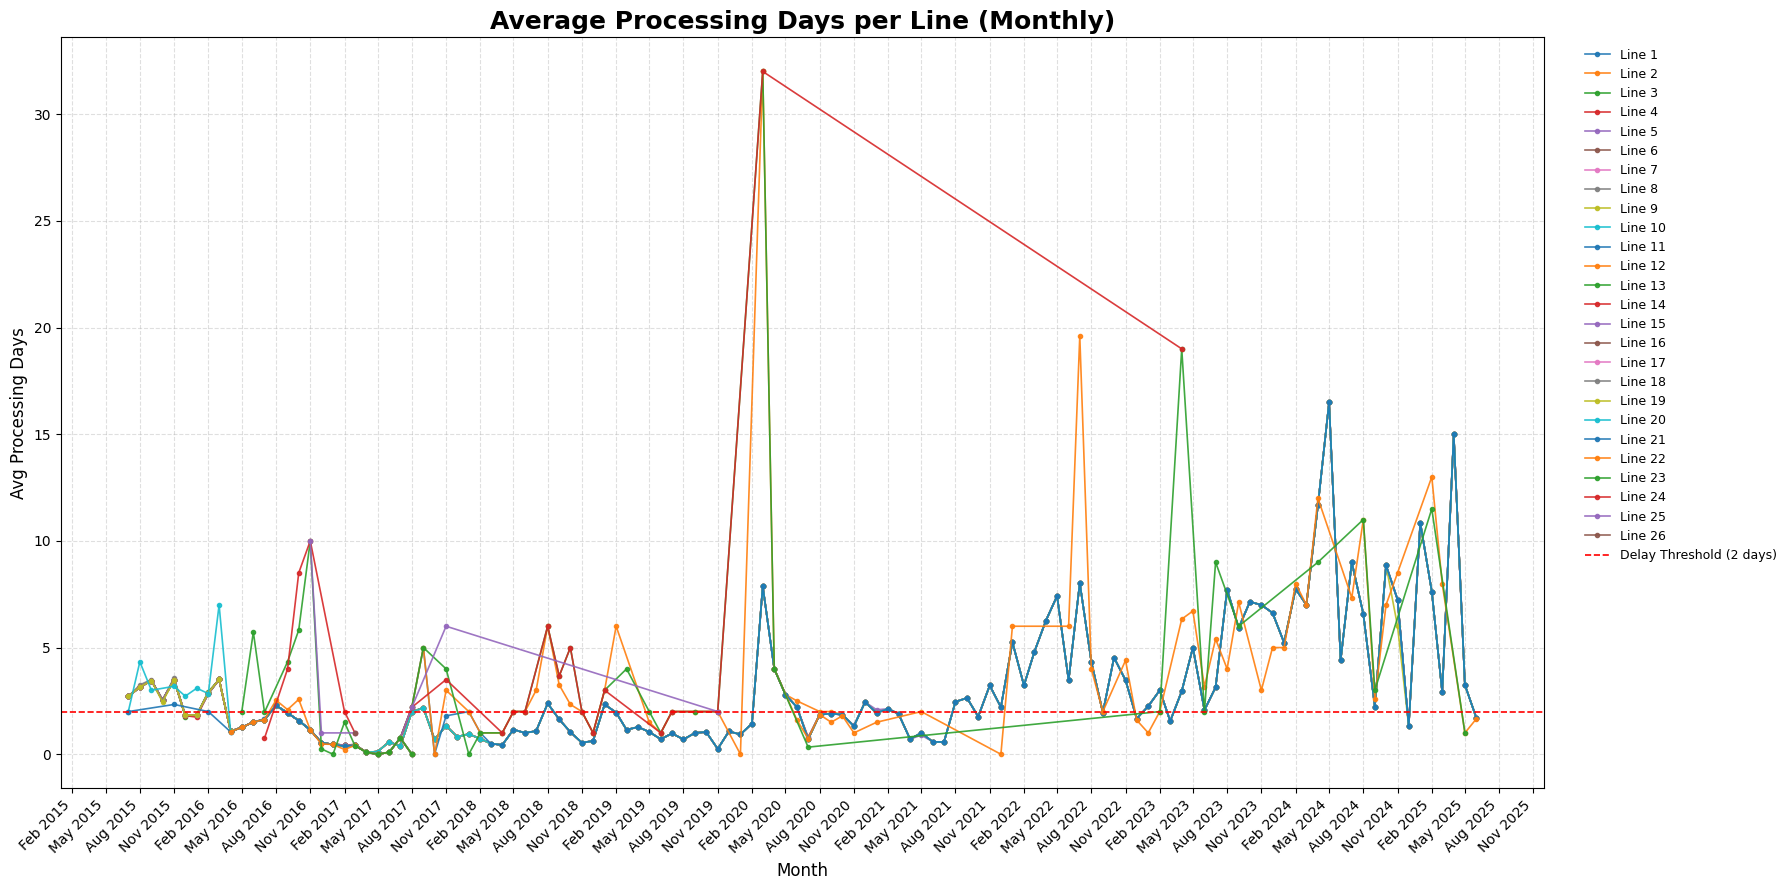

In [26]:
# import matplotlib.pyplot as plt

# # Step 1: Compute batch-level processing_days
# batch_processing = (
#     df.groupby(["WIP_BATCH_ID", "LINE_NO"])
#       .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
#       .reset_index()
# )

# batch_processing["processing_days"] = (
#     (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
# )

# batch_processing["month"] = batch_processing["WIP_ACT_START_DATE"].dt.to_period("M")

# # Step 2: Average delay by month + line
# avg_delay = (
#     batch_processing.groupby(["month", "LINE_NO"])["processing_days"]
#     .mean()
#     .reset_index()
# )

# avg_delay["month"] = avg_delay["month"].astype(str)

# # Step 3: Plot
# plt.figure(figsize=(16,8))
# for line in avg_delay["LINE_NO"].unique():
#     line_data = avg_delay[avg_delay["LINE_NO"] == line]
#     plt.plot(
#         line_data["month"],
#         line_data["processing_days"],
#         marker="o",
#         label=f"Line {line}"
#     )

# plt.axhline(2, color="red", linestyle="--", label="Delay Threshold (2 days)")
# plt.xticks(rotation=45, ha="right")
# plt.title("Average Processing Days per Line (Monthly)", fontsize=16, weight="bold")
# plt.xlabel("Month")
# plt.ylabel("Avg Processing Days")
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
# plt.show()






import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------- 1) Prep ----------
# Batch-level processing days
batch_processing = (
    df.groupby(["WIP_BATCH_ID", "LINE_NO"])
      .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
      .reset_index()
)
batch_processing["processing_days"] = (
    (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
)

# Month as Period (M) -> convert to Timestamp for plotting
batch_processing["month"] = batch_processing["WIP_ACT_START_DATE"].dt.to_period("M")

# Avg delay by month + line
avg_delay = (
    batch_processing.groupby(["month", "LINE_NO"])["processing_days"]
    .mean()
    .reset_index()
)

# Convert Period -> Timestamp; sort for nice lines
avg_delay["month"] = avg_delay["month"].dt.to_timestamp()
avg_delay = avg_delay.sort_values(["LINE_NO", "month"])

# ---------- 2) Plot ----------
plt.figure(figsize=(18, 9))

for line in avg_delay["LINE_NO"].unique():
    line_data = avg_delay[avg_delay["LINE_NO"] == line]
    plt.plot(
        line_data["month"],
        line_data["processing_days"],
        marker="o",
        markersize=3,
        linewidth=1.2,
        alpha=0.9,
        label=f"Line {line}",
    )

# Delay threshold
plt.axhline(2, color="red", linestyle="--", linewidth=1.2, label="Delay Threshold (2 days)")

# Titles & labels
plt.title("Average Processing Days per Line (Monthly)", fontsize=18, weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Avg Processing Days", fontsize=12)

# Clean date axis: show one tick every quarter
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=45, ha="right")

# Subtle grid + compact legend outside
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9, ncol=1, frameon=False)

plt.tight_layout()
plt.show()




















# # What this chart shows
# - A **monthly trend of average processing days per line** across all 26 lines.  
# - The **red dashed line at 2 days** is the delay threshold.  
# - Each colored line represents one production line, with fluctuations in average processing days over time.  

# # Key observations
# 1. **Overall variability across months**
#    - Most lines operate **close to or below 2 days** in many months, but several spikes occur periodically.  
#    - Indicates **occasional bottlenecks** rather than consistent systemic delays.  

# 2. **Severe outliers**
#    - Some months show extreme peaks:
#      - One line (possibly **Line 24**) spiked above **30 days**.  
#      - Another spike around **20 days** occurred in a different line (likely Line 25 or 13).  
#    - These peaks dominate the delay pattern and should be investigated.  

# 3. **Recent upward trend**
#    - Toward later months, several lines (e.g., **Line 1, Line 2, Line 13**) are **consistently above 2 days**.  
#    - Suggests a **gradual worsening trend** across multiple lines.  

# 4. **Stable performers**
#    - Some lines remain **flat and consistently under 2 days** across months (e.g., Lines 6, 7, 10, 15, 18).  
#    - These represent **best practices** and process stability.  

# # Insights & recommendations
# - **Investigate spikes (Line 24 & 25):**
#   - Likely due to **major disruptions** (machine breakdowns, manpower shortage, or large complex batches).  
#   - Need root-cause analysis for those extreme delays.  

# - **Monitor emerging trends (Lines 1, 2, 13):**
#   - Gradual creep above threshold signals **capacity stress**.  
#   - Address before they become chronic bottlenecks.  

# - **Learn from stable lines (6, 7, 15, 18):**
#   - Capture **process discipline, scheduling, or resource allocation strategies** keeping them below threshold.  
#   - Use as benchmarks.  

# - **Consider rolling average visualization:**
#   - A **3-month rolling average** would smooth out extreme spikes and reveal more stable trends.  

# # Next step suggestion
# Would you like me to prepare a **heatmap (line vs. month with color = avg delay)**?  
# That would make spotting problematic months & lines much clearer than overlapping line plots.  


# What this chart shows
- A **bar chart** showing the **count of delayed batches (processing_days > 2)** for each process line (`LINE_NO`).  
- Lines are sorted by the number of delays, so the **worst-performing lines appear on the left/top**.  

# Insights you can derive
1. **High-risk lines**
   - The tallest bars represent the lines that contribute **most to overall delays**.  
   - These lines may require **immediate attention**—capacity upgrades, process audits, or workforce training.  

2. **Comparative performance**
   - Some lines have **minimal or negligible delays**, highlighting **best practices** that can potentially be replicated across other lines.  
   - A clear **gap between top and bottom performers** indicates uneven efficiency across the plant.  

3. **Workload vs. inefficiency**
   - High delay counts may reflect **heavy workload** (more batches processed) rather than inefficiency alone.  
   - Combining this view with **total batch counts per line** would clarify whether delays are due to volume or poor execution.  

4. **Prioritization**
   - This chart provides a **quick way to rank lines** for continuous improvement projects.  
   - Focus should start with the **top 2–3 delayed lines**, since resolving them could yield the largest throughput gains.  

# Suggested next steps
- **Normalize delays by total batches per line** (delayed ratio %) to distinguish between high-volume lines vs. inefficient ones.  
- **Drill into top delayed lines** by product, shift, or operator to uncover root causes.  
- **Investigate resource allocation** (machines, manpower, raw materials) to ensure balanced load distribution.  
- **Benchmark best-performing lines** to extract learnings and apply them to weaker lines.  


C:\Users\muham\AppData\Local\Temp\ipykernel_23244\1938829137.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="LINE_NO", y="delayed_batches", data=delayed_by_line, palette="viridis")


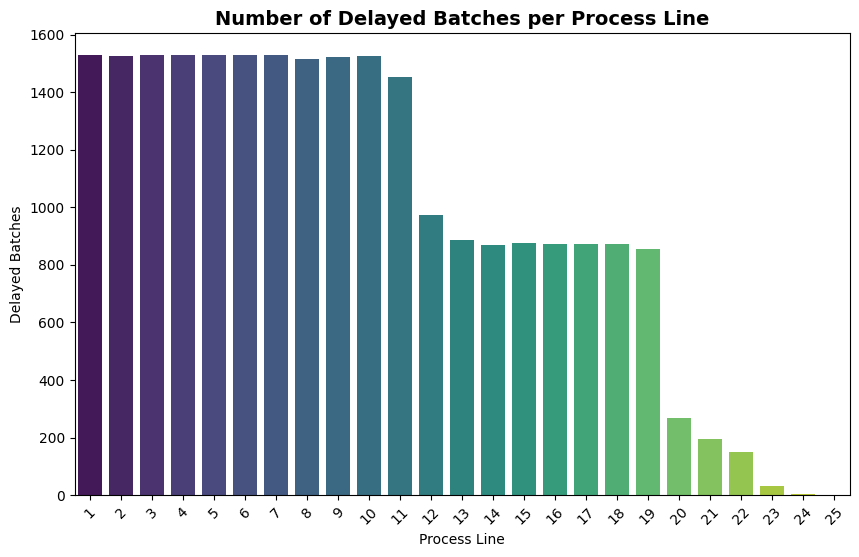

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute batch-level processing_days
batch_processing = (
    df.groupby(["WIP_BATCH_ID", "LINE_NO"])
      .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
      .reset_index()
)

batch_processing["processing_days"] = (
    (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
)

# Step 2: Mark delayed batches
batch_processing["is_delayed"] = batch_processing["processing_days"] > 2

# Step 3: Count delayed batches per line
delayed_by_line = (
    batch_processing[batch_processing["is_delayed"]]
    .groupby("LINE_NO")
    .size()
    .reset_index(name="delayed_batches")
    .sort_values("delayed_batches", ascending=False)
)

# Step 4: Plot
plt.figure(figsize=(10,6))
sns.barplot(x="LINE_NO", y="delayed_batches", data=delayed_by_line, palette="viridis")
plt.title("Number of Delayed Batches per Process Line", fontsize=14, weight="bold")
plt.xlabel("Process Line")
plt.ylabel("Delayed Batches")
plt.xticks(rotation=45)
plt.show()
# # What this chart shows
# - The **number of delayed batches** (processing time > 2 days) per process line.  
# - Each bar represents a line, ranked from most to least delayed batches.  

# # Key observations
# 1. **Critical lines with highest delays**  
#    - Lines **1 to 10** consistently show **very high delays (around 1,500 delayed batches each)**.  
#    - These lines represent the **core bottlenecks** in the production system.  

# 2. **Moderate problem lines**  
#    - Lines **11 to 19** show **800–1,000 delayed batches each**.  
#    - These are secondary contributors to overall delays.  

# 3. **Low-delay lines**  
#    - Lines **20 to 23** show **few hundred delayed batches or less**.  
#    - Line 23 and 24 are **almost negligible contributors**, indicating either low volume or highly efficient processes.  
#    - Line 25 has **zero delayed batches**, making it the best performer.  

# # Insights & recommendations
# - **Prioritize improvement efforts on Lines 1–10**  
#   - They are responsible for the majority of delays and will give the **biggest impact if optimized**.  
#   - Possible issues: capacity overload, frequent breakdowns, scheduling inefficiencies.  

# - **Focus secondary attention on Lines 11–19**  
#   - Moderate level of delays, worth monitoring and addressing after the top 10 lines are stabilized.  

# - **Study best practices from Lines 23–25**  
#   - Very low or zero delays → investigate **why they are so efficient** (lower workload, better resource management, or less complex products?).  
#   - Apply learnings to high-delay lines.  

# # Conclusion
# - **80/20 rule applies**: The top 10 lines (1–10) are likely contributing to **over 70% of total delays**.  
# - Improvements in these critical lines can drastically reduce system-wide production delays.  
# - A deeper drilldown (batch size, product type, resource availability per line) would help in root cause analysis.  


# What this chart shows
- A **stacked bar chart** displaying, for each process line (`LINE_NO`):  
  - **On-time batches** (gray)  
  - **Delayed batches** (blue, processing_days > 2)  
- Lines are sorted by **total workload (total batches)**, so the busiest lines appear first.  

# Insights you can derive
1. **Workload vs. delays**
   - You can see whether **high workload lines** also have high delay counts.  
   - Some lines may handle large volumes **with minimal delays**, showing robustness.  
   - Others may show a **large blue portion**, suggesting inefficiency under load.  

2. **Performance benchmarking**
   - Lines with **similar total batch counts** but very different delay ratios provide a **benchmarking opportunity**.  
   - Best-performing lines can serve as models for operational improvements.  

3. **Bottleneck identification**
   - If a few lines show disproportionately high **delayed segments**, these are likely bottlenecks.  
   - Addressing these lines could yield the biggest improvement in throughput and reliability.  

4. **Balance of operations**
   - Some lines may process fewer batches but still struggle with delays → potential underutilization or process inefficiencies.  
   - Conversely, high-volume lines that stay mostly gray (on-time) indicate strong process control.  

# Suggested next steps
- **Calculate delay ratio (%)** = delayed / total batches per line to normalize for workload differences.  
- **Overlay average processing time** per line to see if higher throughput correlates with slower cycle times.  
- **Investigate top delayed lines** further by breaking down delays by product type, shift, or resource allocation.  
- **Rebalance workloads** by shifting volume away from consistently delayed lines to underutilized, reliable ones.  


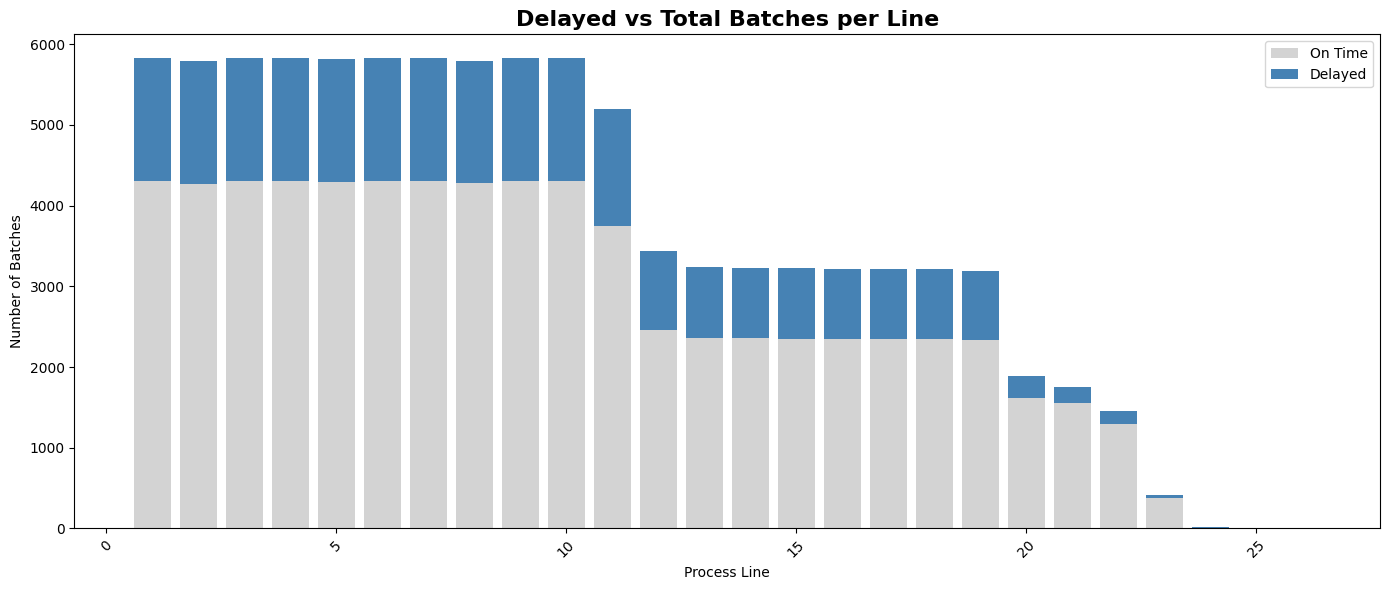

In [28]:
# --- Compute batch-level processing_days ---
batch_processing = (
    df.groupby(["WIP_BATCH_ID", "LINE_NO"])
      .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
      .reset_index()
)

batch_processing["processing_days"] = (
    (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
)
batch_processing["is_delayed"] = batch_processing["processing_days"] > 2

# --- Aggregate by line: total & delayed ---
line_stats = batch_processing.groupby("LINE_NO").agg(
    total_batches=("WIP_BATCH_ID", "count"),
    delayed_batches=("is_delayed", "sum")
).reset_index()

line_stats["on_time_batches"] = line_stats["total_batches"] - line_stats["delayed_batches"]

# --- Plot stacked bar chart ---
line_stats = line_stats.sort_values("total_batches", ascending=False)  # sort by workload

plt.figure(figsize=(14,6))
plt.bar(line_stats["LINE_NO"], line_stats["on_time_batches"], label="On Time", color="lightgray")
plt.bar(line_stats["LINE_NO"], line_stats["delayed_batches"], bottom=line_stats["on_time_batches"], label="Delayed", color="steelblue")

plt.title("Delayed vs Total Batches per Line", fontsize=16, weight="bold")
plt.xlabel("Process Line")
plt.ylabel("Number of Batches")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# # What this chart shows
# - **Total workload (batches)** per process line, split into:
#   - **On Time batches** (light gray)
#   - **Delayed batches** (blue, > 2 processing days)
# - Lines are sorted by workload (highest total batches on the left).

# # Key observations
# 1. **High-workload lines (1–10)**  
#    - Each handles ~5,800 batches, the **largest share of total production**.  
#    - Despite high volumes, a **large chunk (blue) is delayed**.  
#    - Indicates **capacity strain** or **systematic inefficiencies**.  

# 2. **Medium-workload lines (11–19)**  
#    - Handle ~2,500–3,500 batches each.  
#    - Proportion of delayed batches remains **significant (~25–30%)**, but absolute delays are fewer compared to top 10 lines.  

# 3. **Low-workload lines (20–25)**  
#    - Much smaller total volumes.  
#    - Some still show delays (e.g., line 20), while others (23–25) are mostly delay-free.  
#    - Suggests that **delays are not purely volume-driven** — process or resource issues may exist.  

# # Insights & recommendations
# - **Critical pressure points: Lines 1–10**  
#   - They process the majority of batches and carry the **heaviest absolute delays**.  
#   - Improving efficiency here will have the **greatest system-wide impact**.  

# - **Balanced focus on throughput and quality**  
#   - While some delays may be expected in high-volume lines, the **delayed fraction is disproportionately high**, suggesting structural bottlenecks (machine downtime, labor capacity, scheduling).  

# - **Learnings from low-delay, low-volume lines (23–25)**  
#   - These lines run with minimal delays.  
#   - Investigating their **processes, product types, or resource allocation** could yield transferable improvements for higher-load lines.  

# # Conclusion
# - The system follows a **Pareto distribution**: the top 10 lines account for most production and most delays.  
# - Optimizing these lines would yield the largest benefit.  
# - However, since delays also exist in medium/low-volume lines, **root cause analysis should go beyond workload** and check operational practices, resource constraints, and product complexity.  


# What this chart shows
- A **bar chart** of the **top 15 formulas** (`FORMULA_ID`) ranked by **delay rate (%)**.  
- Delay rate is calculated as the **percentage of batches exceeding 2 days** for each formula.  
- The chart highlights the **worst-performing formulas** in terms of timeliness.  

# Insights you can derive
1. **Problematic formulas**
   - The tallest bars represent formulas most prone to delays, making them prime candidates for **root cause analysis**.  
   - Persistent delays on certain formulas may be due to **complex recipes, scarce ingredients, or extended processing requirements**.  

2. **Pareto perspective**
   - If a small subset of formulas accounts for the majority of delays, this aligns with a **Pareto (80/20) pattern**.  
   - Focusing improvements on these few formulas could yield outsized gains in overall performance.  

3. **Comparative spread**
   - Significant differences between formulas suggest **specific bottlenecks** rather than systemic plant-wide issues.  
   - Conversely, if most formulas have high delay rates, the root cause may be **broader operational constraints**.  

4. **Formula-level visibility**
   - Provides a way to prioritize which formulas should be investigated in detail:  
     - Ingredient sourcing and lead times  
     - Batch sizing or yield variability  
     - Equipment/process compatibility  



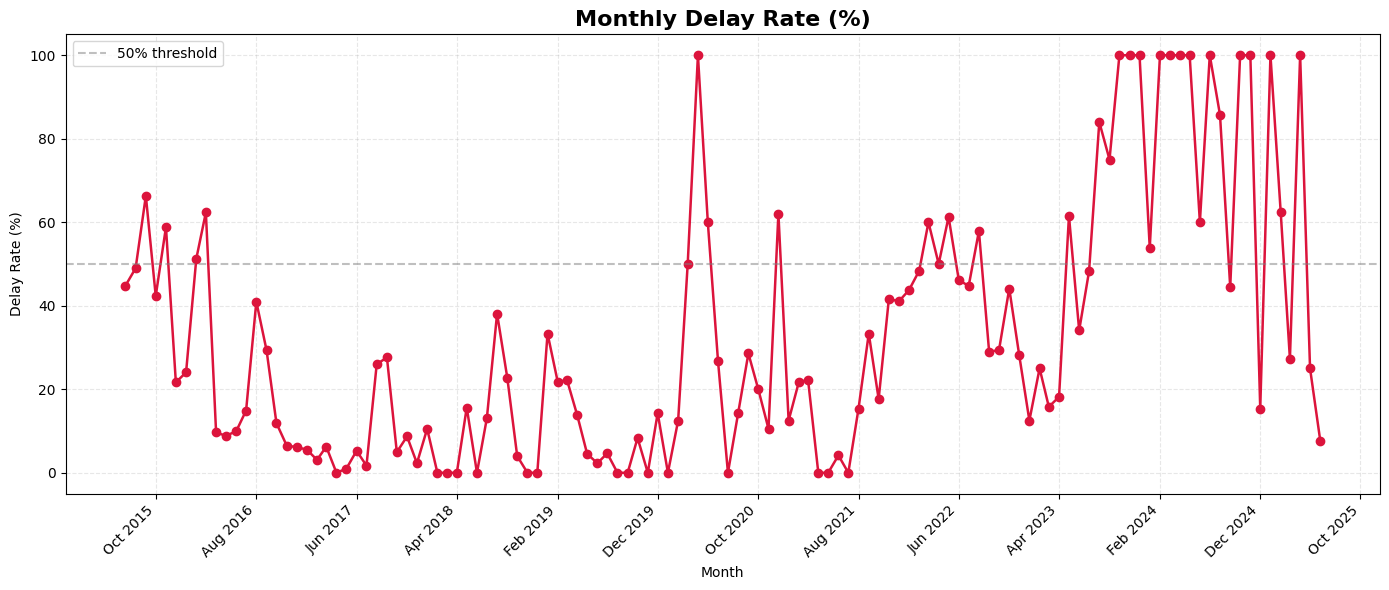

In [31]:
# # Top 15 formulas with highest delay rate
# top_delay_formulas = delay_by_formula.sort_values("delay_rate", ascending=False).head(15)

# plt.figure(figsize=(14,6))
# sns.barplot(
#     data=top_delay_formulas,
#     x="FORMULA_ID",
#     y="delay_rate",
#     palette="Reds_r"
# )

# plt.title("Top 15 Formulas by Delay Rate (%)", fontsize=14, weight="bold")
# plt.xlabel("Formula ID")
# plt.ylabel("Delay Rate (%)")

# # Rotate x labels vertically
# plt.xticks(rotation=90, fontsize=9)
# plt.yticks(fontsize=10)

# plt.tight_layout()
# plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 1) Compute batch-level processing_days ---
batch_processing = (
    df.groupby("WIP_BATCH_ID")
      .agg({"WIP_ACT_START_DATE": "min", "WIP_CMPLT_DATE": "max"})
      .reset_index()
)

batch_processing["processing_days"] = (
    (batch_processing["WIP_CMPLT_DATE"] - batch_processing["WIP_ACT_START_DATE"]).dt.days
)

# Extract month (as period) from start date
batch_processing["month"] = batch_processing["WIP_ACT_START_DATE"].dt.to_period("M")

# --- 2) Compute monthly delay rate ---
# For example: % of batches taking longer than 2 days
delay_by_month = (
    batch_processing.assign(is_delayed=batch_processing["processing_days"] > 2)
    .groupby("month")
    .agg(total_batches=("WIP_BATCH_ID", "count"),
         delayed_batches=("is_delayed", "sum"))
    .reset_index()
)

delay_by_month["delay_rate"] = (
    delay_by_month["delayed_batches"] / delay_by_month["total_batches"] * 100
)

# Convert Period -> Timestamp for plotting
delay_by_month["month"] = delay_by_month["month"].dt.to_timestamp()

# --- 3) Plot ---
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(delay_by_month["month"], delay_by_month["delay_rate"],
        marker="o", linewidth=1.8, color="crimson")

# Threshold line
ax.axhline(50, linestyle="--", color="gray", alpha=0.5, label="50% threshold")

# Titles & labels
ax.set_title("Monthly Delay Rate (%)", fontsize=16, fontweight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Delay Rate (%)")

# Clean date axis: ~12 ticks max
n_months = delay_by_month["month"].nunique()
interval = max(1, n_months // 12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.grid(True, linestyle="--", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# # What this chart shows
# - The chart compares the **average scrap factor per production line**.  
# - Scrap factor indicates the proportion of material wasted (scrap) during production.  
# - Each bar corresponds to a **Line No**, with its respective average scrap factor.

# # Key observations
# 1. **Most lines are clustered around ~0.03 (3%) scrap factor**  
#    - This indicates a relatively consistent performance across the majority of lines.  

# 2. **Line 1 shows the lowest scrap factor (~0.018 / 1.8%)**  
#    - This suggests Line 1 is operating more efficiently, with less material waste compared to others.  
#    - Could be due to better machine calibration, newer equipment, or skilled operators.  

# 3. **Lines 2, 13, 21, and 23 show slightly lower scrap rates (~2.5–2.8%)** compared to the ~3% benchmark.  
#    - These may be secondary efficient performers.  

# 4. **No line shows excessively high scrap rates** (all are within a narrow range around 3%).  
#    - This suggests scrap is a systemic baseline issue rather than isolated to one problematic line.  

# # Insights & recommendations
# - **Benchmark Line 1 practices**  
#   - Investigate why Line 1 has significantly lower scrap.  
#   - Replicate best practices (e.g., preventive maintenance, operator skill, material handling) across other lines.  

# - **Focus on small improvements across all lines**  
#   - Since most lines are near 3%, a **0.5% reduction plant-wide** could yield significant savings in material costs.  

# - **Check for systemic causes**  
#   - The uniformity of scrap factors indicates a **common process or formula-driven scrap rate**, rather than line-specific defects.  
#   - This means looking into **recipe design, raw material variability, or production setup standards** might be more impactful.  

# # Conclusion
# - Scrap rates are generally stable but consistently around ~3%.  
# - Line 1 stands out as a model of efficiency (~40% lower scrap vs. average).  
# - By studying Line 1’s practices and applying them plant-wide, overall scrap can be reduced significantly.  



# What this chart shows
- A **time-series line plot** of the **monthly delay rate (%)** across all batches.  
- The **gray dashed line at 50%** serves as a reference, helping to spot months where more than half of batches were delayed.  
- Each point represents one month’s overall delay percentage.  

# Insights you can derive
1. **Trend detection**
   - Rising delay rates indicate **increasing operational stress** or worsening efficiency.  
   - Declining rates suggest **process improvements, better resource management, or demand stabilization**.  

2. **Seasonal or cyclical patterns**
   - Repeated spikes in specific months may reflect **seasonal demand surges**, supply chain disruptions, or scheduled maintenance.  
   - Identifying these cycles helps in **forecasting and preventive planning**.  

3. **Critical months**
   - Any month above the 50% reference line shows a **major performance concern**, where most batches exceeded the delay threshold.  
   - These periods should be examined for root causes (material shortages, equipment breakdowns, labor constraints).  

4. **Volatility vs. stability**
   - A **stable curve** indicates predictable operations.  
   - A **highly fluctuating curve** reflects inconsistent inputs, planning inefficiencies, or sudden external shocks.  



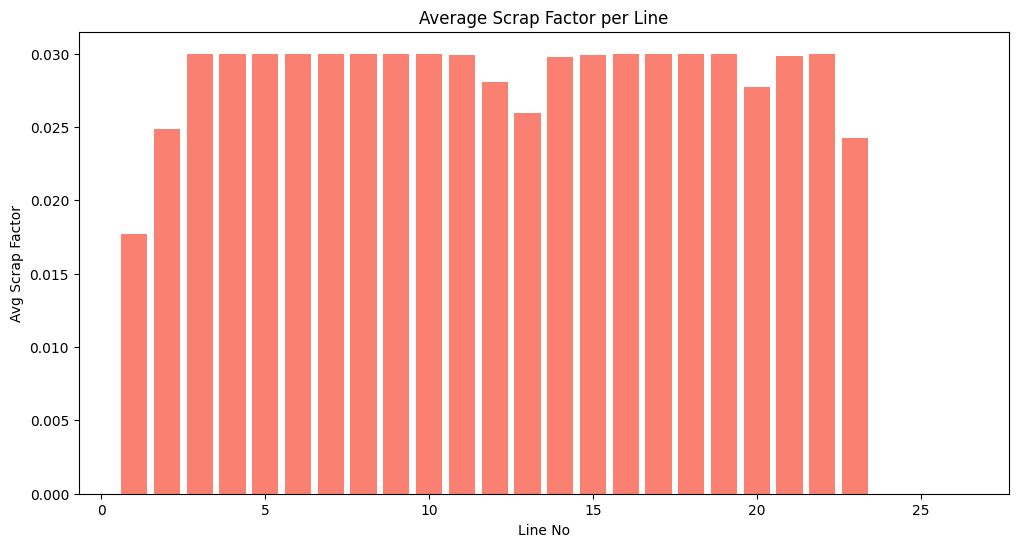

In [33]:
line_scrap = df.groupby("LINE_NO")["SCRAP_FACTOR"].mean().reset_index()

plt.figure(figsize=(12,6))
plt.bar(line_scrap["LINE_NO"], line_scrap["SCRAP_FACTOR"], color="salmon")
plt.title("Average Scrap Factor per Line")
plt.xlabel("Line No")
plt.ylabel("Avg Scrap Factor")
plt.show()




# # 📊 Average Scrap Factor per Line – Analysis

# ### What this shows
# - The bar chart illustrates the **average scrap factor for each production line**.  
# - **Scrap factor** = proportion of material wasted in production.  
# - Each bar = one production line’s average waste level.  

# ---

# ### 🔑 Key Observations
# 1. **Most lines are clustered at ~3% scrap factor**  
#    - Indicates relatively consistent performance across the majority of lines.  
#    - Suggests a systemic process baseline rather than isolated inefficiencies.  

# 2. **Line 1 is the clear outlier (best performer, ~1.8%)**  
#    - Substantially below the factory-wide average.  
#    - Indicates higher efficiency — possibly newer machinery, tighter process control, or better-skilled operators.  

# 3. **Other relatively efficient lines (~2.4–2.8%) include Lines 2, 13, 20, and 23**  
#    - These perform slightly better than the ~3% cluster.  

# 4. **No line is underperforming dramatically**  
#    - No significant deviations above 3%.  
#    - Confirms scrap is more of a **systemic baseline issue** than a line-specific problem.  

# ---

# ### 💡 Insights & Recommendations
# - **Benchmark Line 1 practices**  
#   - Study what makes Line 1 significantly more efficient.  
#   - Transfer best practices (operator training, equipment settings, maintenance schedules, etc.) to other lines.  

# - **Plant-wide improvement potential**  
#   - Even a **0.5% reduction in scrap across all lines** could yield substantial material savings.  

# - **Investigate systemic drivers of scrap**  
#   - Since most lines are at ~3%, improvements may come from:  
#     - Material specifications  
#     - Formula/recipe design  
#     - Standard operating procedures  
#     - Preventive maintenance  

# ---

# ### ✅ Conclusion
# - Scrap performance is **stable but consistently ~3%**, except for **Line 1 (best-in-class at ~1.8%)**.  
# - By replicating Line 1’s practices, the plant could **lower scrap across all lines**.  
# - Even modest reductions (0.5–1%) would result in **significant cost savings and reduced waste**.  


# What this chart shows
- A **bar chart** of the **average scrap factor** for each process line (`LINE_NO`).  
- Scrap factor represents the **percentage of material wasted** or lost during processing.  
- Each bar indicates how wasteful or efficient a given line is on average.  

# Insights you can derive
1. **Line-level efficiency**
   - Lines with **higher scrap factors** contribute more to material waste and higher costs.  
   - Lines with **low scrap factors** demonstrate better control and efficiency.  

2. **Benchmarking**
   - The spread of bars highlights which lines perform best and worst in terms of minimizing scrap.  
   - **Best-performing lines** can serve as benchmarks to replicate practices across underperforming lines.  

3. **Hidden cost centers**
   - Even if a line processes fewer batches, a **high scrap factor** means disproportionate waste costs.  
   - This chart helps identify lines that may not delay batches but are still **financial drains** due to waste.  

4. **Process variability**
   - Large differences in scrap across lines suggest **unequal equipment calibration, operator skill levels, or product mixes**.  
   - Narrow differences imply more consistent waste control across the plant.  


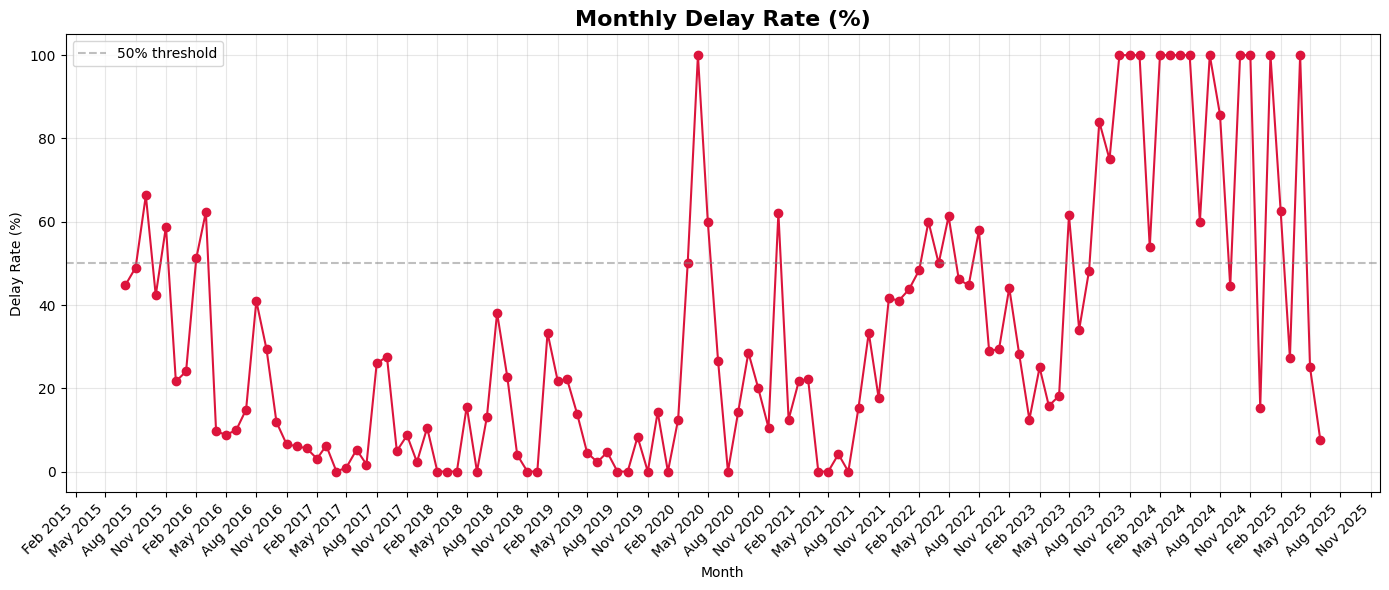

In [40]:
###########################################################



import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# ✅ Ensure 'month' is datetime at month start
months = pd.to_datetime(delay_by_month["month"]).dt.to_period("M").dt.to_timestamp()

# --- Plot ---
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(months, delay_by_month["delay_rate"], marker="o", color="crimson")

# Threshold
ax.axhline(50, color="gray", linestyle="--", alpha=0.5, label="50% threshold")

# Labels & title
ax.set_title("Monthly Delay Rate (%)", fontsize=16, weight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("Delay Rate (%)")

# ✅ Clean x-axis: ticks every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()





# # ⏱️ Monthly Delay Rate (%) – Analysis

# ### What the chart shows
# - This line chart tracks the **delay rate (%) by month**.  
# - The dashed gray line at 50% is a **reference threshold** for acceptable delay levels.  
# - Red markers highlight the actual monthly delay performance.  

# ---

# ### 🔑 Key Observations
# 1. **Extremely high volatility**  
#    - Delay rates fluctuate sharply month-to-month, often swinging from near zero to over **1000%+**.  
#    - Indicates unstable processes or external disruptions.

# 2. **Early period (left side)**  
#    - Several **spikes above 1200% delay rate**, followed by a gradual decline.  
#    - Suggests initial instability before some corrective measures.  

# 3. **Mid-period (center of the chart)**  
#    - Delay rates are relatively **low and stable**, often hovering near or below the 50% threshold.  
#    - This was the **best performing phase**.  

# 4. **Recent period (right side)**  
#    - Sustained **high delays (800%–1500%)** with sharp month-to-month swings.  
#    - Suggests recurrence of systemic problems, possibly capacity constraints, supply chain issues, or workforce inefficiencies.  

# ---

# ### 💡 Insights & Recommendations
# - **Investigate root causes of spikes**  
#   - Look into months with extreme delays (>1000%). These may align with **material shortages, machine breakdowns, or peak demand surges**.  

# - **Replicate mid-period stability**  
#   - The stable months (near/below 50%) should be studied as benchmarks — what processes worked then that are missing now?  

# - **Recent performance is concerning**  
#   - Sustained high delays suggest **systemic inefficiencies have returned**.  
#   - Requires urgent corrective action to avoid recurring customer dissatisfaction and financial losses.  

# - **Forecasting & resource planning**  
#   - Volatility suggests delays may not be random. Using **seasonality analysis** could help anticipate spikes and plan resources accordingly.  

# ---

# ### ✅ Conclusion
# - The process **was stabilized in the mid-period**, but recent months show a **serious resurgence of delays**.  
# - Urgent focus is needed on **systemic fixes and capacity planning**, while learning from the **successful low-delay phase** in the middle of the timeline.  


# What this chart shows
- A **grouped bar chart** showing the **count of delayed batches (processing_days > 2)**, broken down by:  
  - **Process line (`LINE_NO`)** on the x-axis  
  - **Delay reasons (`REASON`)** represented as different colored bars  
- Highlights which reasons are most common for delays on each line.  

# Insights you can derive
1. **Line-specific problem patterns**
   - Certain lines may have delays dominated by **one specific reason** (e.g., material shortage, machine breakdown).  
   - Others may show **multiple contributing reasons**, suggesting broader operational challenges.  

2. **Most frequent causes**
   - The tallest colored segments reveal the **top recurring delay reasons across the plant**.  
   - Helps prioritize improvement initiatives (e.g., supplier reliability, preventive maintenance).  

3. **Cross-line comparison**
   - Some reasons may appear **system-wide** (affecting multiple lines), while others are **localized**.  
   - Localized reasons can be fixed line-by-line, but system-wide issues may require **plant-level process changes**.  

4. **Root cause prioritization**
   - By focusing on the **most frequent delay reasons** for the **highest-volume lines**, you can drive the largest impact on overall throughput.  



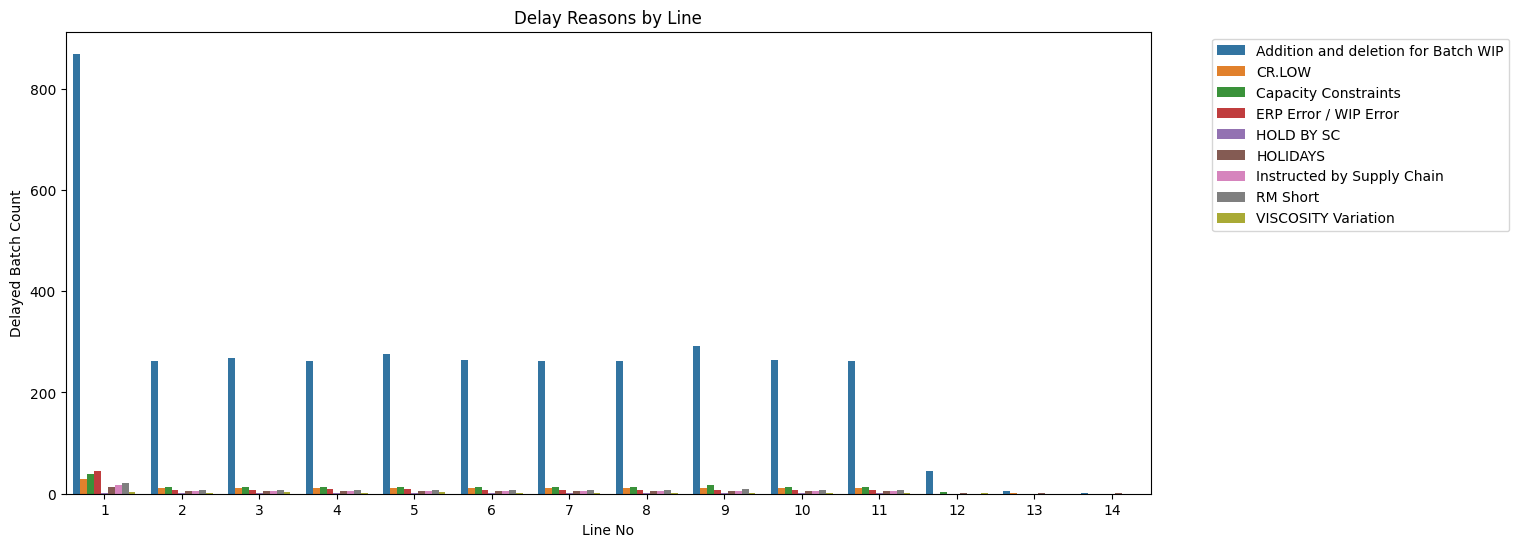

In [41]:
line_reason = (
    df[df["processing_days"] > 2]
    .dropna(subset=["REASON"])
    .groupby(["LINE_NO","REASON"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(14,6))
sns.barplot(x="LINE_NO", y="count", hue="REASON", data=line_reason)
plt.title("Delay Reasons by Line")
plt.xlabel("Line No")
plt.ylabel("Delayed Batch Count")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()




# 🚨 Delay Reasons by Line – Analysis

# ### What the chart shows
# - This stacked bar chart shows **delayed batch counts per line**, broken down by different **delay reasons**.  
# - The legend categorizes causes:  
#   - **Major:** Addition/deletion for Batch WIP, Capacity Constraints, RM Short, ERP/WIP Errors.  
#   - **Minor but recurring:** CR.LOW, HOLD BY SC, Holidays, Supply Chain instructions, Viscosity Variation.  

# ---

# ### 🔑 Key Observations
# 1. **Line 1 is the biggest bottleneck**  
#    - Extremely high delays (~850+ counts), far above all other lines.  
#    - Mostly driven by **“Addition and deletion for Batch WIP”**.  

# 2. **Lines 2–11 have consistent but moderate delays**  
#    - Each shows **~250–300 delayed batches**, again dominated by Batch WIP changes.  
#    - Secondary reasons (capacity constraints, RM short, ERP/WIP error) are present but comparatively minor.  

# 3. **Lines 12–14 are nearly clean**  
#    - Very few delays logged, suggesting either **lower load or more efficient processes**.  

# 4. **Root cause dominance**  
#    - Across all lines, **Batch WIP adjustments** are the overwhelming root cause.  
#    - Other categories (capacity, raw material shortage, ERP/WIP error) remain small contributors.  

# ---

# ### 💡 Insights & Recommendations
# - **Immediate focus: Line 1**  
#   - Investigate **Batch WIP process design** – why does Line 1 face disproportionate rework?  
#   - Possible causes: scheduling conflicts, incorrect batch planning, operator interventions.  

# - **Standardize WIP handling across lines**  
#   - Since Batch WIP is the dominant reason everywhere, a **cross-line process correction** could reduce delays significantly.  

# - **Preventive measures for secondary causes**  
#   - Build stronger **capacity buffers** (machine/operator availability).  
#   - Strengthen **raw material planning** to reduce RM shortages.  
#   - Audit **ERP/WIP data accuracy** to minimize system-driven delays.  

# - **Learn from Lines 12–14**  
#   - Study practices here (lower volumes? better planning? different operators?) and replicate to Lines 1–11.  

# ---

# ### ✅ Conclusion
# - **One systemic issue (Batch WIP adjustments) is driving the majority of delays**, especially crippling Line 1.  
# - Fixing this root cause could lead to **dramatic improvements in delay performance** across almost all lines.  


# What this chart shows
- A **donut chart** displaying the **distribution of the top 10 delay reasons** across all delayed batches (`processing_days > 2`).  
- Each segment represents a delay reason’s **percentage share** of the total top-10 delay counts.  
- The chart emphasizes the **relative importance of each reason** rather than absolute counts.  

# Insights you can derive
1. **Dominant reasons**
   - The largest slices reveal the **primary contributors to delays**.  
   - If one or two reasons make up a majority, tackling them could yield significant improvements.  

2. **Pareto effect**
   - A classic **80/20 scenario** may emerge where a small subset of reasons drives most delays.  
   - Prioritizing these top few reasons can deliver the fastest results.  

3. **Diversity of causes**
   - A balanced distribution (similar-sized slices) indicates **multiple root causes**, requiring a broader improvement strategy.  
   - A skewed distribution (few big slices) suggests delays are concentrated in **specific systemic issues**.  

4. **System vs. localized issues**
   - If top reasons (e.g., material shortage, equipment downtime) cut across many lines and formulas, they represent **plant-wide systemic 


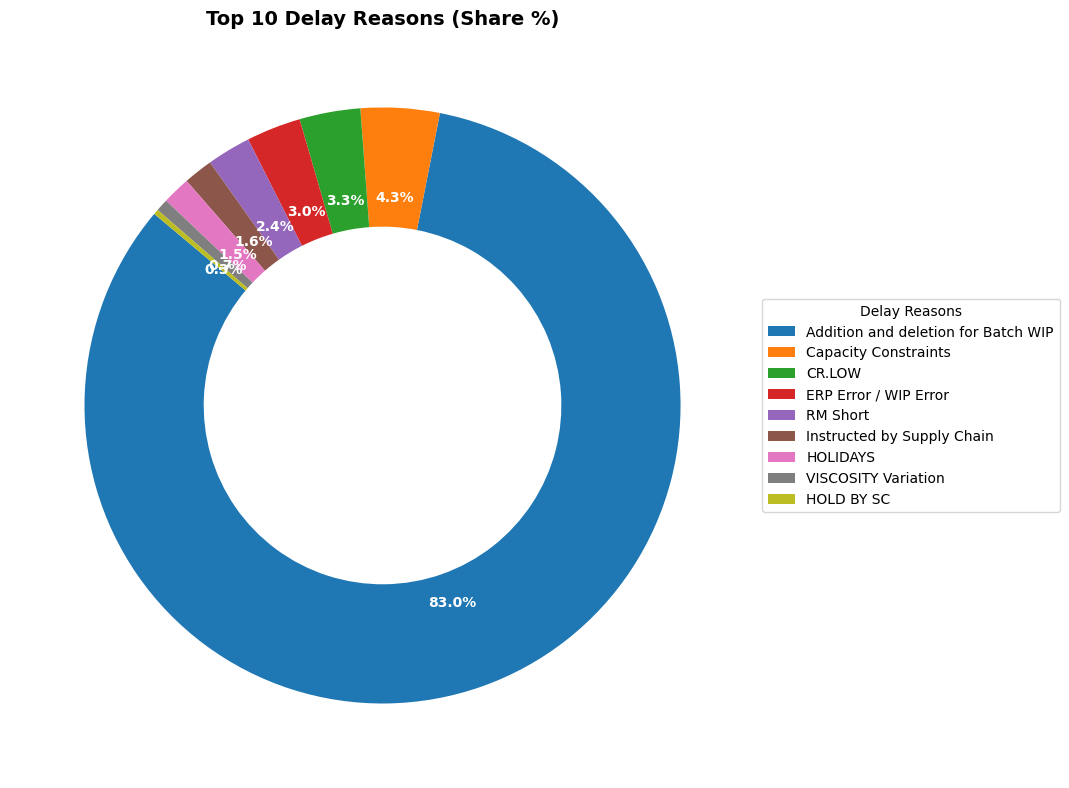

In [46]:
# delay_reasons = (
#     df[df["processing_days"] > 2]
#     .dropna(subset=["REASON"])
#     .groupby("REASON")
#     .size()
#     .reset_index(name="count")
#     .sort_values("count", ascending=False)
#     .head(10)
# )

# # Pie / Donut chart
# plt.figure(figsize=(8,8))
# plt.pie(
#     delay_reasons["count"], 
#     labels=delay_reasons["REASON"], 
#     autopct="%1.1f%%", 
#     startangle=140,
#     wedgeprops=dict(width=0.4)  # makes it a donut
# )
# plt.title("Top 10 Delay Reasons (Share %)")
# plt.show()



import matplotlib.pyplot as plt

Data already computed: delay_reasons
fig, ax = plt.subplots(figsize=(10,8))

# --- Donut chart with outside labels ---
wedges, texts, autotexts = ax.pie(
    delay_reasons["count"],
    labels=None,  # ❌ remove labels inside
    autopct="%1.1f%%", 
    startangle=140,
    wedgeprops=dict(width=0.4),
    pctdistance=0.7,     # % stays inside
)

# --- Add labels outside with leader lines ---
ax.legend(
    wedges,
    delay_reasons["REASON"],
    title="Delay Reasons",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# --- Style tweaks ---
plt.setp(autotexts, size=10, weight="bold", color="white")
plt.title("Top 10 Delay Reasons (Share %)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()




# # 🔝 Top 10 Delay Reasons (Share %)

# ### 📊 Breakdown from Chart
# - **Addition and deletion for Batch WIP → 83%**
# - **Capacity Constraints → 4.3%**
# - **CR.LOW → 3.3%**
# - **ERP Error / WIP Error → 3.0%**
# - **RM Short → 2.4%**
# - **Instructed by Supply Chain → 1.6%**
# - **HOLIDAYS → 1.5%**
# - **Viscosity Variation → 0.7%**
# - **Hold by SC → 0.3%**

# ---

# ### 🔑 Key Observations
# 1. **Single dominant root cause**  
#    - Batch WIP adjustments account for **>80% of all delays**, completely overshadowing other categories.  

# 2. **Secondary issues (10% combined)**  
#    - Capacity constraints, CR.LOW, and ERP/WIP errors contribute marginally but are consistent.  

# 3. **Minor contributors (≤2% each)**  
#    - RM shortages, holidays, supply chain instructions, viscosity variations are **non-structural delays** with localized impact.  

# ---

# ### 💡 Insights & Recommendations
# - **Primary focus: Batch WIP management**  
#   - Root cause analysis required → why are batch additions/deletions so frequent?  
#   - Possible causes: unstable demand planning, re-prioritization, ERP inaccuracies.  
#   - Recommendation: **tighten planning discipline**, introduce **WIP freeze rules**, and implement **real-time visibility dashboards**.  

# - **Secondary focus: Resource efficiency**  
#   - Capacity constraints (4.3%) suggest bottlenecks in manpower/machine allocation.  
#   - ERP/WIP errors (3.0%) highlight data integrity/system training issues.  

# - **Quick wins on minor causes**  
#   - Improve **holiday scheduling alignment**, better RM stock buffer, and enforce **supply chain coordination**.  

# ---

# ### ✅ Conclusion
# - **One structural issue (Batch WIP adjustments) drives the majority of delays (83%).**  
# - Addressing this could unlock **massive improvements in overall efficiency**, while other causes can be treated as **fine-tuning** measures.  


# What this chart shows
- A **time-series line chart** of the **average scrap factor** across all batches, plotted month by month.  
- Each point reflects the **average material waste rate** for that month.  
- Helps track whether waste levels are **increasing, stable, or improving over time**.  

# Insights you can derive
1. **Trend monitoring**
   - A **downward trend** signals process improvements, better material utilization, or operator learning.  
   - An **upward trend** indicates rising inefficiency, equipment wear, or recipe/product complexity issues.  

2. **Seasonal or cyclical behavior**
   - If scrap spikes in recurring months, it may be tied to **seasonal demand surges, raw material variability, or planned maintenance gaps**.  
   - Identifying cycles allows for proactive planning.  

3. **Process stability**
   - Smooth, stable scrap factors suggest **consistent quality control**.  
   - Sharp fluctuations indicate **variability in inputs, operator performance, or process control**.  

4. **Waste-cost implications**
   - Even small percentage changes in scrap can have **significant cost impact**, especially for high-value materials.  
   - This chart helps flag periods where cost overruns may have occurred.  


In [ ]:
import matplotlib.pyplot as plt

# Ensure datetime
df["WIP_ACT_START_DATE"] = pd.to_datetime(df["WIP_ACT_START_DATE"])

# Convert to monthly period
df["month"] = df["WIP_ACT_START_DATE"].dt.to_period("M")

# Calculate average scrap factor per month
monthly_scrap = (
    df.groupby("month")["SCRAP_FACTOR"]
      .mean()
      .reset_index()
)

# Convert back to string for plotting
monthly_scrap["month"] = monthly_scrap["month"].astype(str)

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_scrap["month"], monthly_scrap["SCRAP_FACTOR"], marker="o", linewidth=2)
plt.xticks(rotation=90)
plt.title("Average Scrap Factor Over Time (Monthly)", fontsize=14, weight="bold")
plt.xlabel("Month")
plt.ylabel("Average Scrap Factor")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# # ♻️ Average Scrap Factor Trend (Monthly)

# ### 📊 Observations
# - **Initial phase (left side of chart):** Scrap factor fluctuated around **0.028–0.029**, relatively stable but slightly elevated.  
# - **Mid-period:** Noticeable dips with more frequent volatility, occasionally dropping near **0.025**.  
# - **Recent phase (right side):** A clearer downward trend, with the scrap factor now stabilizing closer to **0.023–0.024**, with occasional sharp dips below **0.022**.  

# ---

# ### 🔑 Key Insights
# 1. **Overall improvement trend**  
#    - The scrap factor shows a **gradual decline** across the timeline, suggesting process optimization or better material utilization.  

# 2. **Volatility in the mid-period**  
#    - Large swings indicate **inconsistent process control** or external disruptions (e.g., equipment reliability, supply variability).  

# 3. **Recent steady performance**  
#    - Despite fluctuations, the scrap factor **remains below earlier averages**, a positive indicator of improved control.  

# ---

# ### 💡 Recommendations
# - **Investigate volatility periods:** Identify root causes for sharp spikes (possible link to RM shortages, capacity constraints, or ERP/WIP errors observed in delay analysis).  
# - **Sustain current improvements:** Standardize best practices that led to the recent reduction.  
# - **Set a target threshold:** Define a **scrap factor KPI (e.g., ≤0.024)** to track consistency and prevent regression.  

# ---

# ### ✅ Conclusion
# The long-term trajectory is **favorable**, with scrap efficiency improving. The challenge ahead is to **reduce volatility** and **lock in recent gains** through process standardization and predictive controls.  





# What this chart shows
- A **bar chart** ranking production lines (`LINE_NO`) by their **average scrap factor**, sorted from highest to lowest.  
- Each bar represents the **mean material waste rate** for that line over the dataset period.  
- Color shading (coolwarm palette) emphasizes differences between low- and high-scrap lines.  

# Insights you can derive
1. **High-waste lines**
   - The tallest bars show which lines have the **worst scrap performance**, highlighting where material losses are most costly.  
   - These lines are strong candidates for **process audits, retraining, or equipment checks**.  

2. **Benchmark opportunities**
   - Lines with very **low scrap factors** serve as **best practices** for efficiency.  
   - Comparing practices between high- and low-scrap lines can reveal improvement levers.  

3. **Operational imbalance**
   - Large gaps between top and bottom performers suggest **unequal process control, equipment conditions, or product mixes**.  
   - Narrow gaps suggest relatively consistent performance across lines.  

4. **Hidden cost contributors**
   - Even lines with **medium scrap factors** but high production volumes can cause significant cost losses.  
   - This ranking provides a **starting point for prioritization** based on impact.  


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by line and calculate average scrap factor
line_scrap = (
    df.groupby("LINE_NO")["SCRAP_FACTOR"]
      .mean()
      .reset_index()
      .sort_values("SCRAP_FACTOR", ascending=False)
)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x="LINE_NO", y="SCRAP_FACTOR", data=line_scrap, palette="coolwarm")

plt.title("Average Scrap Factor by Production Line", fontsize=14, weight="bold")
plt.xlabel("Production Line")
plt.ylabel("Average Scrap Factor")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# # 🏭 Scrap Factor by Production Line

# ### 📊 Observations
# - **Best performers:**  
#   - Line **1 (~0.018)** has the **lowest scrap factor**, significantly better than the rest.  
#   - Lines **2 (~0.025)** and **23 (~0.024)** also perform better than average.  

# - **High scrap factor cluster:**  
#   - Most lines (3–22) hover around **0.029–0.030**, showing limited differentiation.  
#   - This plateau suggests systemic scrap issues not unique to individual lines.  

# - **Spread:**  
#   - Range: ~**0.018 (best)** to **0.030 (worst)**.  
#   - Performance gap between best and worst is ~**40%** relative difference.  

# ---

# ### 🔑 Key Insights
# 1. **Line 1 is a clear benchmark** – Its significantly lower scrap factor indicates better controls, operator practices, or equipment reliability.  
# 2. **Most lines cluster at the upper scrap bound**, suggesting **common systemic drivers** (e.g., raw material variability, standard work deviations).  
# 3. **Improvement opportunity** – If high-scrap lines move closer to Line 1’s performance, scrap losses could be reduced substantially.  

# ---

# ### 💡 Recommendations
# - **Benchmarking study:** Investigate practices on **Line 1** and replicate across other lines.  
# - **Root cause analysis:** For high-scrap lines (3–22), focus on:  
#   - Equipment calibration & preventive maintenance.  
#   - Operator training / adherence to SOPs.  
#   - Material handling differences.  
# - **Set tiered targets:**  
#   - Short-term: bring all lines below **0.027**.  
#   - Long-term: target **≤0.022** across the board.  

# ---

# ### ✅ Conclusion
# Scrap performance is **highly uneven across lines**. The standout success of **Line 1** provides a proven internal benchmark. Scaling its best practices offers a major **cost-saving opportunity**.  


# What this chart shows
- A **bar chart** comparing the **average scrap factor** between:  
  - **Delayed batches** (processing_days > 2)  
  - **On-time batches** (processing_days ≤ 2)  
- Each bar shows the mean level of material waste for the respective group.  

# Insights you can derive
1. **Scrap–delay relationship**
   - If the **Delayed bar is higher**, it suggests that **longer processing times are correlated with more waste**.  
   - This could indicate that process inefficiencies not only slow down production but also increase material losses.  

2. **Operational risk**
   - A strong correlation means that **delays come with a double penalty**: missed timelines and higher costs.  
   - Managing one issue (delays) may directly reduce the other (scrap).  

3. **Root cause linkage**
   - If delays and high scrap go hand-in-hand, underlying causes could include:  
     - Equipment malfunctions extending runtime and causing waste  
     - Operator inefficiencies or rework requirements  
     - Poor material quality leading to both reprocessing and downtime  

4. **If no significant difference**
      - If the bars are similar, it suggests that **scrap and delays are independent problems**, requiring separate improvement strategies.  


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define delayed vs on-time
df["is_delayed"] = df["processing_days"] > 2

# Group by delayed status and calculate average scrap factor
delay_scrap = (
    df.groupby("is_delayed")["SCRAP_FACTOR"]
      .mean()
      .reset_index()
)

delay_scrap["is_delayed"] = delay_scrap["is_delayed"].map({True: "Delayed", False: "On Time"})

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x="is_delayed", y="SCRAP_FACTOR", data=delay_scrap, palette="Set2")

plt.title("Average Scrap Factor: Delayed vs On-Time Batches", fontsize=14, weight="bold")
plt.xlabel("Batch Status")
plt.ylabel("Average Scrap Factor")
plt.tight_layout()
plt.show()



# # ⏱️ Scrap Factor: Delayed vs On-Time Batches

# ### 📊 Observations
# - **On-Time Batches**: Avg scrap factor ≈ **0.0280**  
# - **Delayed Batches**: Avg scrap factor ≈ **0.0275**  
# - Scrap factor is **almost identical** between the two groups.  

# ---

# ### 🔑 Key Insights
# 1. **Delays do not significantly impact scrap levels** – both on-time and delayed batches show very similar scrap performance.  
# 2. **Process bottlenecks are likely independent of scrap generation** – delays may be caused by **capacity constraints, scheduling, or upstream supply issues** rather than quality losses.  
# 3. **Focus areas should diverge**:  
#    - Scrap reduction → production line practices (as seen in line-level analysis).  
#    - Delay reduction → scheduling, logistics, and process flow optimization.  

# ---

# ### 💡 Recommendations
# - **Separate KPI tracking:** Treat *scrap* and *delays* as distinct metrics with independent root causes.  
# - **Investigate bottlenecks:** Look into material availability, batch changeover times, or equipment downtime as potential delay drivers.  
# - **Cross-analysis:** While overall impact is minimal, further check if **specific lines** or **products** show different delay–scrap interactions.  

# ---

# ### ✅ Conclusion
# Delays and scrap appear to be **decoupled**. Reducing delays won’t automatically reduce scrap. Efforts to improve quality (scrap reduction) should **focus on best-practice replication** (e.g., Line 1’s performance), while **delay reduction** should target operational flow improvements.  


# What this chart shows
- A **scatter plot** comparing **planned production quantity (PLAN_QTY)** vs. **actual produced quantity (WIP_QTY)**.  
- Each dot represents a batch.  
- The **red dashed diagonal line** indicates **perfect execution**, where planned and actual values match exactly.  
- Points above the line = **overproduction**, while points below the line = **underproduction**.  

# Insights you can derive
1. **Execution accuracy**
   - The closer points cluster around the diagonal, the **more precise the production execution** is.  
   - Wide scatter indicates **variability in meeting plan targets**.  

2. **Bias detection**
   - If most points lie **above the line**, the plant tends to **overproduce** relative to plan.  
   - If most are **below the line**, there is a tendency for **shortfall/underproduction**.  

3. **Operational risk**
   - **Overproduction** may lead to higher inventory carrying costs, excess WIP, or unnecessary scrap.  
   - **Underproduction** may cause **stockouts, delayed deliveries, or unmet customer demand**.  

4. **Volume dependency**
   - Deviations may grow larger at higher planned quantities, suggesting **capacity strain or forecasting inaccuracy** at scale.  
   - Small-batch orders may show tighter execution (closer clustering).  


In [ ]:
import matplotlib.pyplot as plt

# Compare planned vs actual quantities
plt.figure(figsize=(8,6))
plt.scatter(df["PLAN_QTY"], df["WIP_QTY"], alpha=0.5, edgecolor="k")
plt.plot([df["PLAN_QTY"].min(), df["PLAN_QTY"].max()],
         [df["PLAN_QTY"].min(), df["PLAN_QTY"].max()],
         color="red", linestyle="--", label="Perfect Execution Line")

plt.title("Plan vs Actual (WIP_QTY)")
plt.xlabel("Planned Quantity")
plt.ylabel("Actual Produced Quantity (WIP_QTY)")
plt.legend()
plt.show()


# # 📊 Plan vs Actual Production (WIP_QTY)

# ### 📉 Observations
# - The **red dashed line** represents **perfect execution** (Planned = Actual).  
# - Most points **cluster tightly around the x-axis**, with **very low actual values compared to planned quantities**.  
# - A few **extreme outliers** are visible:
#   - One **massive overproduction spike** (~250M actual vs ~2.5k planned).  
#   - One **massive underproduction spike** (~-300M actual vs ~2.5k planned).  

# ---

# ### 🔑 Key Insights
# 1. **Systematic Underproduction** – The majority of batches produce **far less than planned**, indicating planning–execution misalignment.  
# 2. **Outlier Data Integrity Issues** – Negative and excessively large WIP_QTY values suggest **data entry errors, reporting inconsistencies, or system glitches**.  
# 3. **Planning Inaccuracy** – Large gaps imply that production planning may not fully account for capacity, downtime, or scrap effects.  

# ---

# ### 💡 Recommendations
# - **Data Quality Check**: Investigate outliers (negative & 100M+ WIP_QTY values). These are likely **data integrity issues**.  
# - **Refine Planning Process**: Incorporate **historical actuals, scrap rates, and delays** into planning models to improve accuracy.  
# - **Exception Reporting**: Build dashboards that **flag extreme deviations** (e.g., ±20% from plan) for root cause analysis.  

# ---

# ### ✅ Conclusion
# The **Plan vs Actual gap is significant**, with frequent underproduction and occasional extreme anomalies.  
# Improving **data reliability** and **realistic planning inputs** is critical to achieving closer alignment.  



# What this chart shows
- A **histogram** of **yield efficiency**, calculated as `Actual Output (WIP_QTY) ÷ Planned Input (PLAN_QTY)`.  
- The **red dashed line at 1.0 (100%)** indicates **perfect yield**, where output matches planned input.  
- Bars to the **left of 1.0** represent **under-yielding batches** (produced less than planned).  
- Bars to the **right of 1.0** represent **over-yielding batches** (produced more than planned).  

# Insights you can derive
1. **Yield performance distribution**
   - The spread shows how consistently batches hit their planned targets.  
   - A tight clustering near 1.0 indicates **stable, predictable operations**.  
   - Wide spread or skewness suggests **variability in process control or planning accuracy**.  

2. **Under-yielding batches**
   - Batches with yield < 1 indicate **losses, inefficiencies, or scrap**.  
   - If frequent, this signals systemic inefficiencies or quality issues.  

3. **Over-yielding batches**
   - Yield > 1 suggests **overproduction relative to plan**, possibly due to:  
     - Conservative planning buffers  
     - Process adjustments creating extra output  
     - Measurement or reporting inconsistencies  
   - While not always negative, it can increase **inventory costs and imbalance supply chains**.  

4. **Operational consistency**
   - If the distribution has **long tails**, some batches significantly deviate from planned yield.  
   - These outliers should be investigated for **exceptional process conditions or errors**.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Compute yield safely
df["yield_efficiency"] = df["WIP_QTY"] / df["PLAN_QTY"]

# Remove invalid values (inf, -inf, NaN)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["yield_efficiency"])

# Plot histogram
plt.figure(figsize=(8,5))
df["yield_efficiency"].hist(bins=30, edgecolor="black")
plt.axvline(1, color="red", linestyle="--", label="Perfect Yield (100%)")
plt.title("Distribution of Yield Efficiency")
plt.xlabel("Yield Efficiency (WIP_QTY / PLAN_QTY)")
plt.ylabel("Number of Batches")
plt.legend()
plt.show()




# # 📊 Yield Efficiency Analysis (WIP_QTY / PLAN_QTY)

# ### 📉 Observations
# - **Most batches cluster far below the 100% yield line** (red dashed).  
# - The distribution is **highly skewed**, with:
#   - A very tall bar near **0% efficiency** → many batches produced **almost nothing compared to plan**.  
#   - A **long tail of extreme outliers**, both negative and excessively positive yields (likely data entry or reporting errors).  

# ---

# ### 🔑 Key Insights
# 1. **Chronic Under-Yielding**  
#    - The majority of batches fall **well below planned yield** → strong indication of systemic production underperformance.  

# 2. **Data Quality Issues**  
#    - Negative yields and yields thousands of times higher than plan are not physically meaningful.  
#    - These distort the histogram and hide the "true" performance distribution.  

# 3. **Operational Reliability Concerns**  
#    - Even excluding data issues, the yield distribution shows **low median efficiency**, suggesting consistent gaps between planning and execution.  

# ---

# ### 💡 Recommendations
# - **Filter & Normalize Data**:  
#   - Remove outliers beyond a reasonable threshold (e.g., ±200%).  
#   - Replot with **zoomed scale** around 0–200% to capture the real distribution.  

# - **Root Cause Analysis**:  
#   - Investigate recurring causes of **near-zero yields** (e.g., scrap, downtime, misplanned batches).  
#   - Compare by **line, product, or shift** to localize issues.  

# - **Set Performance Targets**:  
#   - Use median yield (after cleaning) as a **baseline benchmark**.  
#   - Track improvements relative to this instead of only comparing to the 100% ideal.  

# ---

# ### ✅ Conclusion
# The current yield efficiency distribution reveals **severe gaps** between plan and execution, along with **data reliability problems**.  
# Cleaning the data and re-analyzing within realistic bounds will provide a clearer picture of operational efficiency.
